# Wavelet denoising

author: laquitainesteeve@gmail.com

Dataset:
* 60 secs synthetic extracellular recording trace

Pipeline:
* Stationary wavelet Transform (translation invariant)
* Haar wavelet
* Hard thresholding of detail coefficients
* Universal threshold
* High-pass filtering by zero-ing approximation coefficients from a 5-level decomposition of a 16Khz sampling freq.
    * Cutoff frequency: 250.0 Hz

In [1]:
import numpy as np
import os
from scipy.signal import detrend
from sklearn.preprocessing import MinMaxScaler
from pywt import Wavelet, threshold, wavedec, waverec
import pywt
from matplotlib import pyplot as plt
from scipy import signal

### Create custom functions

In [2]:
def NearestEvenInteger(n):
    """! Returns the nearest even integer to number n.

    @param n Input number for which one requires the nearest even integer

    @return The even nearest integer to the input number
    """
    if n % 2 == 0:
        res = n
    else:
        res = n - 1
    return res


def std(trace, nlevel=5):
    """Estimates the standard deviation of the input trace for rescaling
    the Wavelet's coefficients.

    Returns
        Standard deviation of the input trace as (1D ndarray)
    """
    sigma = np.array([1.4825 * np.median(np.abs(trace[i])) for i in range(nlevel)])
    return sigma


def mad(x):
    """Mean absolute deviation"""
    return 1.482579 * np.median(np.abs(x - np.median(x)))


def get_universal_threshold(trace):
    num_samples = len(trace)
    sd = mad(trace)
    return sd * np.sqrt(2 * np.log(num_samples))


def get_han_threshold(trace: np.array, sigma: np.array, coeffs: np.array, nlevels: int):

    # count samples
    num_samples = len(trace)

    # han et al threshold
    details_threshs = np.array([np.nan] * len(coeffs[1:]))

    # threshold for first detail coeff d_i=0
    details_threshs[0] = sigma[1] * np.sqrt(2 * np.log(num_samples))

    # threshold from 1 < d_i < NLEVELS
    for d_i in range(1, nlevels - 1):
        details_threshs[d_i] = (sigma[d_i] * np.sqrt(2 * np.log(num_samples))) / np.log(
            d_i + 1
        )
    # threhsold for d_i = nlevels
    details_threshs[nlevels - 1] = (
        sigma[nlevels - 1] * np.sqrt(2 * np.log(num_samples))
    ) / np.sqrt(nlevels - 1)
    return details_threshs


def determine_threshold(
    trace: np.array,
    threshold: str = "han",
    sigma: np.array = None,
    coeffs: np.array = None,
    nlevels: int = None,
):
    if threshold == "universal":
        thr = get_universal_threshold(trace)
    elif threshold == "han":
        thr = get_han_threshold(trace, sigma, coeffs, nlevels)
    else:
        raise NotImplementedError("Choose an implemented threshold!")
    return thr

### Load Quiroga's dataset

* url: http://www.spikesorting.com/simulated-data.aspx
* sampling frequency: 16 Khz

In [3]:
# download simulated dataset 01
!curl -o ../dataset/data_01.txt http://www.spikesorting.com/Data/Sites/1/download/simdata/Quiroga/01%20Example%201%20-%200-05/data_01.txt

# get project path
os.chdir("../")
proj_path = os.getcwd()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100 37.0M  100 37.0M    0     0  26.1M      0  0:00:01  0:00:01 --:--:-- 26.1M


In [4]:
# dataset parameters
SFREQ = 16000
nyquist = SFREQ / 2

In [5]:
# load dataset
trace_01 = np.loadtxt(proj_path + "/dataset/data_01.txt")
tmp_trace = trace_01.copy()

# describe
duration_secs = len(tmp_trace) / SFREQ
num_samples = len(tmp_trace)
print("duration:", duration_secs, "secs")
print("number of samples:", num_samples)

tmp_trace

duration: 90.0 secs
number of samples: 1440000


array([-0.05265172, -0.03124187, -0.00282162, ...,  0.01798155,
        0.01678863,  0.0119459 ])

### 1. Parametrize

The maximum frequency of the lowest frequency band ($F_c$) is given by:
        
$$F_c = Nq/(2^{NLEVEL})$$

where Nq is the Nyquist frequency of the signal (its sampling frequency/2) and NLEVEL is the number of decomposition levels of the wavelet transform.

We chose the decomposition level NLEVEL=6 that produces the lowest frequency band between 0 and 250 Hz 


In [6]:
# TODO:
# - implement Han et al., threshold
# - clear approximation threshold

WAVELET = "haar"
NLEVEL = 5
THRESH = "han"  # "universal"
THRESH_METHOD = "hard"  # 'soft'
RECON_MODE = "zero"  # 'smooth', "symmetric", "antisymmetric", "zero", "constant", "periodic", "reflect",

# calculate cutoff frequency
freq_cutoff = nyquist / 2**NLEVEL  # cutoff frequency (the max of lowest freq. band)
print("Cutoff frequency for high-pass filtering :", freq_cutoff, "Hz")

Cutoff frequency for high-pass filtering : 250.0 Hz


### 2. Preprocess

In [51]:
# detrend
detrended = detrend(tmp_trace)

# normalize data
scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
detrended = scaler.fit_transform(detrended.reshape(-1, 1))[:, 0]
normalized = detrended.copy()

### 3. Wavelet transform

In [52]:
# find the nearest even integer to input signal's length
size = NearestEvenInteger(normalized.shape[0])

# initialize filter
wavelet = Wavelet(WAVELET)

# compute Wavelet coefficients
# coeffs = wavedec(normalized[:size], wavelet, level=NLEVEL)

# translation-invariance modification of the Discrete Wavelet Transform
# that does not decimate coefficients at every transformation level.
coeffs = pywt.swt(normalized[:size], wavelet, level=NLEVEL, trim_approx=True)
coeffs_raw = coeffs.copy()

# print approximation and details coefficients
print("approximation coefficients:", coeffs_raw[0])
print("details coefficients:", coeffs_raw[1:])

approximation coefficients: [2.83647772 2.84106911 2.84452235 ... 2.83109023 2.83292184 2.83465441]
details coefficients: [array([-0.00950856, -0.00603211, -0.00248562, ..., -0.01120825,
       -0.0104237 , -0.00988739]), array([-0.01276296,  0.00053794,  0.0101203 , ..., -0.03684457,
       -0.03087185, -0.02255869]), array([-0.0351023 , -0.02894606, -0.01932213, ..., -0.00506488,
       -0.019433  , -0.0299413 ]), array([-0.01386091, -0.01500663, -0.01406618, ...,  0.00959663,
        0.01430558, -0.00087641]), array([-0.00386154, -0.00512596, -0.00548882, ...,  0.00021516,
        0.00087345,  0.01160962])]


### 4. Denoise

In [65]:
THRESH = "han"

# estimate the wavelet coefficients standard deviations
sigma = std(coeffs[1:], nlevel=NLEVEL)

# determine the thresholds of the coefficients per level ('universal')
# threshs = [
#     determine_threshold(
#         trace=coeffs[1 + level] / sigma[level],
#         threshold=THRESH,
#         sigma=sigma,
#         coeffs=coeffs,
#         nlevels=NLEVEL,
#     )
#     * sigma[level]
#     for level in range(NLEVEL)
# ]

# determine the thresholds of the coefficients per level ('han')
threshs = get_han_threshold(
    trace=tmp_trace,
    sigma=sigma,
    coeffs=coeffs,
    nlevels=NLEVEL,
)

# a list of 5 thresholds for "universal"
# apply the thresholds to the detail coeffs
coeffs[1:] = [
    threshold(coeff_i, value=threshs[i], mode=THRESH_METHOD)
    for i, coeff_i in enumerate(coeffs[1:])
]

In [67]:
# reconstruct and reverse normalize
# denoised_trace = waverec(coeffs, filter, mode=RECON_MODE)
# denoised_trace = scaler.inverse_transform(denoised_trace.reshape(-1, 1))[:, 0]

# reconstruct and reverse normalize
denoised_trace = pywt.iswt(coeffs, wavelet)
denoised_trace = scaler.inverse_transform(denoised_trace.reshape(-1, 1))[:, 0]

### 5. High-pass filter

* High-pass filtering with NLEVEL = 5 decomposition levels is removing the lowest frequency band from 0-1600 Hz ((16000/2) / 5 = 1600 Hz).

In [68]:
# clear approximation coefficients (set to 0)
coeffs[0] = np.zeros(len(coeffs[0]))

# sanity check
assert sum(coeffs[0]) == 0, "not cleared"

### 6. Reconstruct trace

In [69]:
# reconstruct and reverse normalize
# denoised_trace = waverec(coeffs, filter, mode=RECON_MODE)
# denoised_trace = scaler.inverse_transform(denoised_trace.reshape(-1, 1))[:, 0]

# reconstruct and reverse normalize
denoised_trace = pywt.iswt(coeffs, wavelet)
denoised_trace = scaler.inverse_transform(denoised_trace.reshape(-1, 1))[:, 0]

### Plot

#### Traces in the time domain

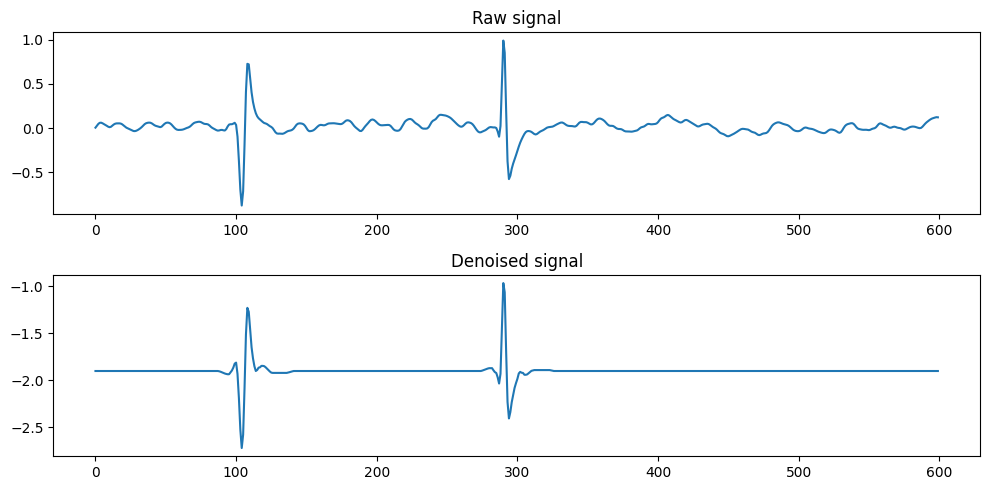

In [70]:
fig = plt.figure(figsize=(10, 5))

# raw
ax = fig.add_subplot(211)
ax.plot(tmp_trace[200:800])
ax.set_title("Raw signal")

# denoised
ax = fig.add_subplot(212)
ax.plot(denoised_trace[200:800])
ax.set_title("Denoised signal")

plt.tight_layout()

#### Power spectrum

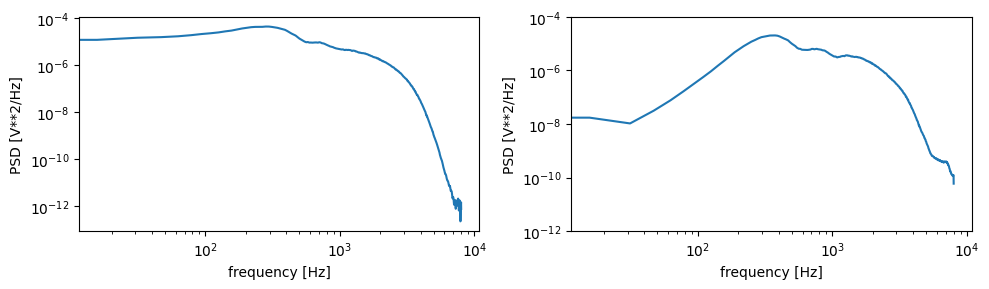

In [71]:
fs = 16e3  # 16 KHz sampling frequency

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Welch method
freqs, powers = signal.welch(tmp_trace, fs, nperseg=1024)
axes[0].plot(freqs, powers)
axes[0].semilogy(basex=10)
axes[0].semilogx(basey=10)
axes[0].set_xlabel("frequency [Hz]")
axes[0].set_ylabel("PSD [V**2/Hz]")


# Welch method
freqs, powers = signal.welch(denoised_trace, fs, nperseg=1024)
axes[1].plot(freqs, powers)
axes[1].semilogy(basex=10)
axes[1].semilogx(basey=10)
axes[1].set_ylim([1e-12, 1e-4])
axes[1].set_xlabel("frequency [Hz]")
axes[1].set_ylabel("PSD [V**2/Hz]")

plt.tight_layout()

# References

(1) Wiltschko, Gage, and Berke, “Wavelet Filtering before Spike Detection Preserves Waveform Shape and Enhances Single-Unit Discrimination.” J Neurosci Methods (2008).

(2) Baldazzi et al., “Systematic Analysis of Wavelet Denoising Methods for Neural Signal Processing.”, Journal of Neural Engineering (2020)